The two questions that I am answering are: 
    1)What are the key factors driving the nightly rental price for units in the Austin area?
    2)Segment the Airbnb properties in the Austin area into different groups. Provide a
    profile of each segment. Which segments command the highest nightly rates? Which
    segments get the best guest ratings? Which segments have the highest percentage of
    “booked” units?

To begin the coding I imported all possible tools I would need to build out the models I am using

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

I loaded the file to inspected the data and to see the data type and the number of non-null in the CSV file 

In [2]:
# Load Data
data_path = 'airbnb_listings_austin.csv'

ATX_lisitng_dat = pd.read_csv(data_path)

ATX_lisitng_dat.info()
print(ATX_lisitng_dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5835 non-null   int64  
 1   listing_url                  5835 non-null   object 
 2   name                         5835 non-null   object 
 3   summary                      5373 non-null   object 
 4   space                        4475 non-null   object 
 5   description                  5832 non-null   object 
 6   experiences_offered          5835 non-null   object 
 7   neighborhood_overview        3572 non-null   object 
 8   notes                        2410 non-null   object 
 9   transit                      3492 non-null   object 
 10  host_id                      5835 non-null   int64  
 11  host_name                    5820 non-null   object 
 12  host_since                   5820 non-null   object 
 13  host_location     

I wanted to check to see the percentage of non-vlaues in each columbs to deiscide if dropping them would be needed. 

In [3]:
ATX_lisitng_dat.isna().sum()/len(ATX_lisitng_dat)*100

id                              0.000000
listing_url                     0.000000
name                            0.000000
summary                         7.917738
space                          23.307626
description                     0.051414
experiences_offered             0.000000
neighborhood_overview          38.783205
notes                          58.697515
transit                        40.154242
host_id                         0.000000
host_name                       0.257069
host_since                      0.257069
host_location                   0.428449
host_about                     31.893745
host_response_time             28.414739
host_response_rate             28.414739
host_is_superhost               0.257069
host_listings_count             0.257069
host_has_profile_pic            0.257069
host_identity_verified          0.257069
neighbourhood                  17.737789
city                            0.000000
property_type                   0.000000
room_type       

In [4]:
ATX_lisitng_dat.dtypes

id                               int64
listing_url                     object
name                            object
summary                         object
space                           object
description                     object
experiences_offered             object
neighborhood_overview           object
notes                           object
transit                         object
host_id                          int64
host_name                       object
host_since                      object
host_location                   object
host_about                      object
host_response_time              object
host_response_rate              object
host_is_superhost               object
host_listings_count            float64
host_has_profile_pic            object
host_identity_verified          object
neighbourhood                   object
city                            object
property_type                   object
room_type                       object
accommodates             

In [5]:
ATX_lisitng_dat['experiences_offered'] = ATX_lisitng_dat['experiences_offered'].str.title()
ATX_lisitng_dat_1= ATX_lisitng_dat['experiences_offered'].unique()
ATX_lisitng_dat_1.sort()
ATX_lisitng_dat_1

array(['None'], dtype=object)

In [6]:
ATX_lisitng_dat['amenities'] = ATX_lisitng_dat['amenities'].str.title()
ATX_lisitng_dat_2= ATX_lisitng_dat['amenities'].unique()
ATX_lisitng_dat_2.sort()
ATX_lisitng_dat_2

array(['{"Air Conditioning","Free Parking On Premises",Heating,"Family/Kid Friendly","Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials}',
       '{"Air Conditioning","Free Parking On Premises",Heating,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher"}',
       '{"Air Conditioning","Pets Live On This Property",Cat(S),"Other Pet(S)","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer}',
       ..., '{Tv,Internet,"Wireless Internet",Kitchen}',
       '{Tv,Internet,"Wireless Internet",Pool,Kitchen,"Free Parking On Premises",Heating,Washer,Dryer,Shampoo}',
       '{}'], dtype=object)

In [7]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['host_location'] = ATX_lisitng_dat['host_location'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
ATX_lisitng_dat_3 = ATX_lisitng_dat['host_location'].unique()
ATX_lisitng_dat_3 = sorted(ATX_lisitng_dat_3)

# Display the sorted unique values
ATX_lisitng_dat_3

[' Asturias. Spain',
 '1/2 Time Nyc , 1/2 Time Hk',
 'Aldie, Virginia, United States',
 'Alicante, Valencian Community, Spain',
 'All Over The World!',
 'Allen, Texas, United States',
 'Alpine, Texas, United States',
 'Ames, Iowa, United States',
 'Arkansas',
 'Austin',
 'Austin / Dc / Cape Cod',
 'Austin, Texas',
 'Austin, Texas, United States',
 'Austin, Tx',
 'Australia & Austin',
 'Baltimore, Maryland, United States',
 'Bangkok, Thailand',
 'Baton Rouge, Louisiana, United States',
 'Berkeley, California, United States',
 'Berlin, Berlin, Germany',
 'Birmingham, Alabama, United States',
 'Blacklick, Ohio, United States',
 'Blacksburg, Virginia, United States',
 'Boston, Massachusetts, United States',
 'Brechin, Scotland, United Kingdom',
 'Brooklyn, New York',
 'Ca',
 'California',
 'Cambridge, Massachusetts, United States',
 'Cary, North Carolina, United States',
 'Centennial, Colorado, United States',
 'Central',
 'Charlottesville, Virginia, United States',
 'Chennai, Tamil Nadu, 

In [8]:
ATX_lisitng_dat['property_type'] = ATX_lisitng_dat['property_type'].str.title()
ATX_lisitng_dat_4= ATX_lisitng_dat['property_type'].unique()
ATX_lisitng_dat_4.sort()
ATX_lisitng_dat_4

array(['Apartment', 'Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin',
       'Camper/Rv', 'Chalet', 'Condominium', 'Earth House', 'House',
       'Hut', 'Loft', 'Other', 'Tent', 'Tipi', 'Townhouse', 'Treehouse',
       'Villa'], dtype=object)

In [9]:
ATX_lisitng_dat['room_type'] = ATX_lisitng_dat['room_type'].str.title()
ATX_lisitng_dat_5= ATX_lisitng_dat['room_type'].unique()
ATX_lisitng_dat_5.sort()
ATX_lisitng_dat_5

array(['Entire Home/Apt', 'Private Room', 'Shared Room'], dtype=object)

In [10]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['host_is_superhost'] = ATX_lisitng_dat['host_is_superhost'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
ATX_lisitng_dat_6 = ATX_lisitng_dat['host_is_superhost'].unique()
ATX_lisitng_dat_6 = sorted(ATX_lisitng_dat_6)

# Display the sorted unique values
ATX_lisitng_dat_6

['F', 'T', 'Unknown']

In [11]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['host_identity_verified'] = ATX_lisitng_dat['host_identity_verified'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
ATX_lisitng_dat_7 = ATX_lisitng_dat['host_identity_verified'].unique()
ATX_lisitng_dat_7 = sorted(ATX_lisitng_dat_7)

# Display the sorted unique values
ATX_lisitng_dat_7

['F', 'T', 'Unknown']

In [12]:
# drop non-numeric columns 

ATX_lisitng_dat_num = ATX_lisitng_dat.drop(columns=['id','listing_url', 'name', 'summary', 'space', 'description','experiences_offered','neighborhood_overview','notes','transit','host_id','host_name','host_since','host_about','host_response_time','host_response_rate','host_has_profile_pic','neighbourhood','city','amenities','square_feet','host_location','host_listings_count','weekly_price','security_deposit','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_value','cleaning_fee','property_type','room_type','bed_type','cancellation_policy', 'has_availability', 'review_scores_location'])

In [13]:
ATX_lisitng_dat_num.dtypes

host_is_superhost          object
host_identity_verified     object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
price                      object
guests_included             int64
extra_people               object
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
instant_bookable           object
dtype: object

In [14]:
#changing vars to bino 
ATX_lisitng_dat_num["host_is_superhost"] = ATX_lisitng_dat_num["host_is_superhost"].apply(lambda x: 1 if x == 'T' else 0)
ATX_lisitng_dat_num['host_identity_verified'] = ATX_lisitng_dat_num['host_identity_verified'].apply(lambda x: 1 if x == 'T' else 0)
ATX_lisitng_dat_num['instant_bookable'] = ATX_lisitng_dat_num['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)

In [15]:
ATX_lisitng_dat_num.dtypes
#create dummies for:
#property_type 
#room_type
#bed_type
#cancellation_policy
#bathrooms


#Fix
# extra_people       
# price           


#new dropped 
##review_scores_rating
#review_scores_accuracy
#review_scores_cleanliness
#review_scores_checkin
#review_scores_communication
#review_scores_value



host_is_superhost           int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
price                      object
guests_included             int64
extra_people               object
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
instant_bookable            int64
dtype: object

In [16]:
# Ensure all values are strings and capitalize them
ATX_lisitng_dat['price'] = ATX_lisitng_dat_num['price'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
ATX_lisitng_dat_num_1 = ATX_lisitng_dat['price'].unique()
ATX_lisitng_dat_num_1 = sorted(ATX_lisitng_dat_num_1)

# Display the sorted unique values
ATX_lisitng_dat_num_1


['$0.00 ',
 '$1,000.00 ',
 '$1,025.00 ',
 '$1,050.00 ',
 '$1,056.00 ',
 '$1,079.00 ',
 '$1,090.00 ',
 '$1,099.00 ',
 '$1,100.00 ',
 '$1,109.00 ',
 '$1,120.00 ',
 '$1,150.00 ',
 '$1,175.00 ',
 '$1,199.00 ',
 '$1,200.00 ',
 '$1,249.00 ',
 '$1,250.00 ',
 '$1,299.00 ',
 '$1,300.00 ',
 '$1,349.00 ',
 '$1,350.00 ',
 '$1,380.00 ',
 '$1,389.00 ',
 '$1,395.00 ',
 '$1,400.00 ',
 '$1,432.00 ',
 '$1,450.00 ',
 '$1,475.00 ',
 '$1,495.00 ',
 '$1,500.00 ',
 '$1,545.00 ',
 '$1,570.00 ',
 '$1,595.00 ',
 '$1,597.00 ',
 '$1,600.00 ',
 '$1,650.00 ',
 '$1,665.00 ',
 '$1,690.00 ',
 '$1,695.00 ',
 '$1,700.00 ',
 '$1,725.00 ',
 '$1,750.00 ',
 '$1,795.00 ',
 '$1,800.00 ',
 '$1,850.00 ',
 '$1,859.00 ',
 '$1,899.00 ',
 '$1,900.00 ',
 '$1,999.00 ',
 '$10,000.00 ',
 '$100.00 ',
 '$101.00 ',
 '$102.00 ',
 '$103.00 ',
 '$104.00 ',
 '$105.00 ',
 '$106.00 ',
 '$107.00 ',
 '$108.00 ',
 '$109.00 ',
 '$110.00 ',
 '$111.00 ',
 '$112.00 ',
 '$113.00 ',
 '$114.00 ',
 '$115.00 ',
 '$116.00 ',
 '$118.00 ',
 '$119.00 ',
 '$120

In [17]:
# Clean the 'price' column by removing unwanted characters and converting to numeric
ATX_lisitng_dat_num['price'] = (
    ATX_lisitng_dat_num['price']
    .str.replace('$', '', regex=False)   # Remove dollar sign
    .str.replace(',', '')               # Remove commas
    .str.strip()                        # Remove extra spaces
    .astype(float)                      # Convert to numeric type
)

In [18]:
ATX_lisitng_dat_num['extra_people'] = ATX_lisitng_dat_num['extra_people'].fillna('Unknown').astype(str).str.title()

# Get unique values and sort them
ATX_lisitng_dat_num_2 = ATX_lisitng_dat['extra_people'].unique()
ATX_lisitng_dat_num_2 = sorted(ATX_lisitng_dat_num_2)

# Display the sorted unique values
ATX_lisitng_dat_num_2

['$0.00 ',
 '$10.00 ',
 '$100.00 ',
 '$11.00 ',
 '$118.00 ',
 '$12.00 ',
 '$125.00 ',
 '$129.00 ',
 '$14.00 ',
 '$15.00 ',
 '$150.00 ',
 '$16.00 ',
 '$17.00 ',
 '$18.00 ',
 '$185.00 ',
 '$19.00 ',
 '$20.00 ',
 '$200.00 ',
 '$22.00 ',
 '$24.00 ',
 '$25.00 ',
 '$250.00 ',
 '$26.00 ',
 '$27.00 ',
 '$270.00 ',
 '$28.00 ',
 '$29.00 ',
 '$30.00 ',
 '$300.00 ',
 '$33.00 ',
 '$35.00 ',
 '$39.00 ',
 '$40.00 ',
 '$400.00 ',
 '$45.00 ',
 '$49.00 ',
 '$5.00 ',
 '$50.00 ',
 '$500.00 ',
 '$52.00 ',
 '$55.00 ',
 '$58.00 ',
 '$59.00 ',
 '$6.00 ',
 '$60.00 ',
 '$65.00 ',
 '$69.00 ',
 '$7.00 ',
 '$70.00 ',
 '$75.00 ',
 '$8.00 ',
 '$80.00 ',
 '$85.00 ',
 '$89.00 ',
 '$9.00 ',
 '$90.00 ',
 '$95.00 ',
 '$96.00 ',
 '$99.00 ']

In [19]:
# Clean the 'price' column by removing unwanted characters and converting to numeric
ATX_lisitng_dat_num['extra_people'] = (
    ATX_lisitng_dat_num['extra_people']
    .str.replace('$', '', regex=False)   # Remove dollar sign
    .str.replace(',', '')               # Remove commas
    .str.strip()                        # Remove extra spaces
    .astype(float)                      # Convert to numeric type
)

In [20]:
ATX_lisitng_dat_num.dtypes

host_is_superhost           int64
host_identity_verified      int64
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
price                     float64
guests_included             int64
extra_people              float64
minimum_nights              int64
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
number_of_reviews           int64
review_scores_rating      float64
instant_bookable            int64
dtype: object

In [21]:
ATX_lisitng_dat_num.head(5)

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,0,0,6,2.5,1.0,3.0,300.0,1,0.0,2,0,0,0,240,1,100.0,0
1,0,1,2,0.0,1.0,1.0,99.0,1,0.0,3,29,59,89,364,0,NaN,0
2,0,1,2,1.5,1.0,1.0,100.0,1,0.0,1,30,60,90,365,0,NaN,0
3,0,1,2,1.5,1.0,1.0,100.0,1,0.0,1,30,60,90,365,0,NaN,0
4,0,1,6,2.0,3.0,3.0,599.0,1,0.0,2,27,57,87,358,0,NaN,0


In [22]:
ATX_lisitng_dat_num['bathrooms'] = ATX_lisitng_dat_num['bathrooms'].fillna(ATX_lisitng_dat_num['bathrooms'].median())
ATX_lisitng_dat_num['beds'] = ATX_lisitng_dat_num['beds'].fillna(ATX_lisitng_dat_num['beds'].median())
ATX_lisitng_dat_num['bedrooms'] = ATX_lisitng_dat_num['bedrooms'].fillna(ATX_lisitng_dat_num['bedrooms'].median())
ATX_lisitng_dat_num['review_scores_rating'] = ATX_lisitng_dat_num['review_scores_rating'].fillna(ATX_lisitng_dat_num['review_scores_rating'].median())

In [23]:
#Standardize Data
dfcolumns = ATX_lisitng_dat_num.columns.values.tolist()

scaler = StandardScaler()

df_scaled = scaler.fit_transform(ATX_lisitng_dat_num.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=dfcolumns)

df_scaled.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,instant_bookable
0,-0.406655,-1.432960,0.599453,1.325490,-0.649428,0.478564,0.034271,-0.496572,-0.458426,-0.018229,-1.341017,-1.495466,-1.595780,-0.248596,-0.385566,0.613259,-0.313778
1,-0.406655,0.697856,-0.888185,-1.910050,-0.649428,-0.735268,-0.464245,-0.496572,-0.458426,0.160838,1.012609,0.962058,0.908488,0.787964,-0.424930,0.278613,-0.313778
2,-0.406655,0.697856,-0.888185,0.031274,-0.649428,-0.735268,-0.461764,-0.496572,-0.458426,-0.197296,1.093769,1.003711,0.936626,0.796323,-0.424930,0.278613,-0.313778
3,-0.406655,0.697856,-0.888185,0.031274,-0.649428,-0.735268,-0.461764,-0.496572,-0.458426,-0.197296,1.093769,1.003711,0.936626,0.796323,-0.424930,0.278613,-0.313778
4,-0.406655,0.697856,0.599453,0.678382,1.110633,0.478564,0.775843,-0.496572,-0.458426,-0.018229,0.850290,0.878752,0.852213,0.737807,-0.424930,0.278613,-0.313778


In [24]:
nulls_per_column = df_scaled.isnull().sum()
print(nulls_per_column)

host_is_superhost         0
host_identity_verified    0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
price                     0
guests_included           0
extra_people              0
minimum_nights            0
availability_30           0
availability_60           0
availability_90           0
availability_365          0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
dtype: int64


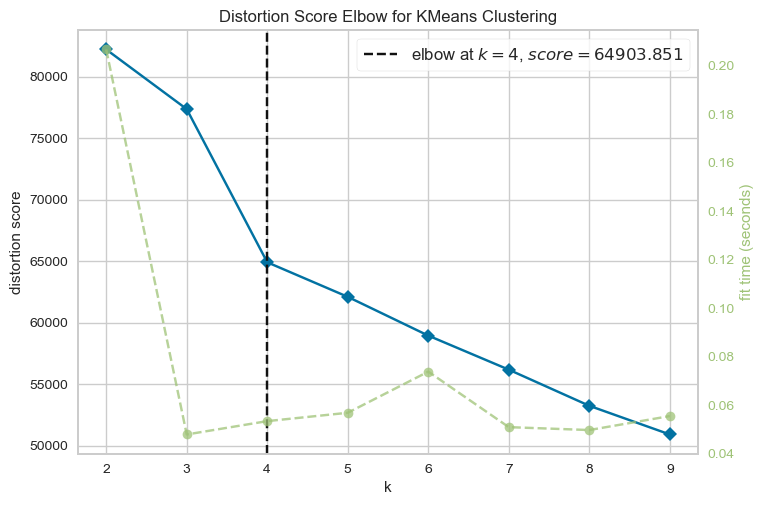

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(df_scaled)
visualizer.show()

In [26]:
kmeans = KMeans(n_clusters=5, random_state=904)
kmclus=kmeans.fit(df_scaled)

clusters = kmeans.fit_predict(df_scaled)

#append cluster to original data
ATX_lisitng_dat_num['cluster']=clusters

ATX_lisitng_dat_num.info()

print(ATX_lisitng_dat_num['cluster'].value_counts())

df_desc = ATX_lisitng_dat_num.groupby('cluster').mean()
print(df_desc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5835 entries, 0 to 5834
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_is_superhost       5835 non-null   int64  
 1   host_identity_verified  5835 non-null   int64  
 2   accommodates            5835 non-null   int64  
 3   bathrooms               5835 non-null   float64
 4   bedrooms                5835 non-null   float64
 5   beds                    5835 non-null   float64
 6   price                   5835 non-null   float64
 7   guests_included         5835 non-null   int64  
 8   extra_people            5835 non-null   float64
 9   minimum_nights          5835 non-null   int64  
 10  availability_30         5835 non-null   int64  
 11  availability_60         5835 non-null   int64  
 12  availability_90         5835 non-null   int64  
 13  availability_365        5835 non-null   int64  
 14  number_of_reviews       5835 non-null   

Price


<Figure size 800x400 with 0 Axes>

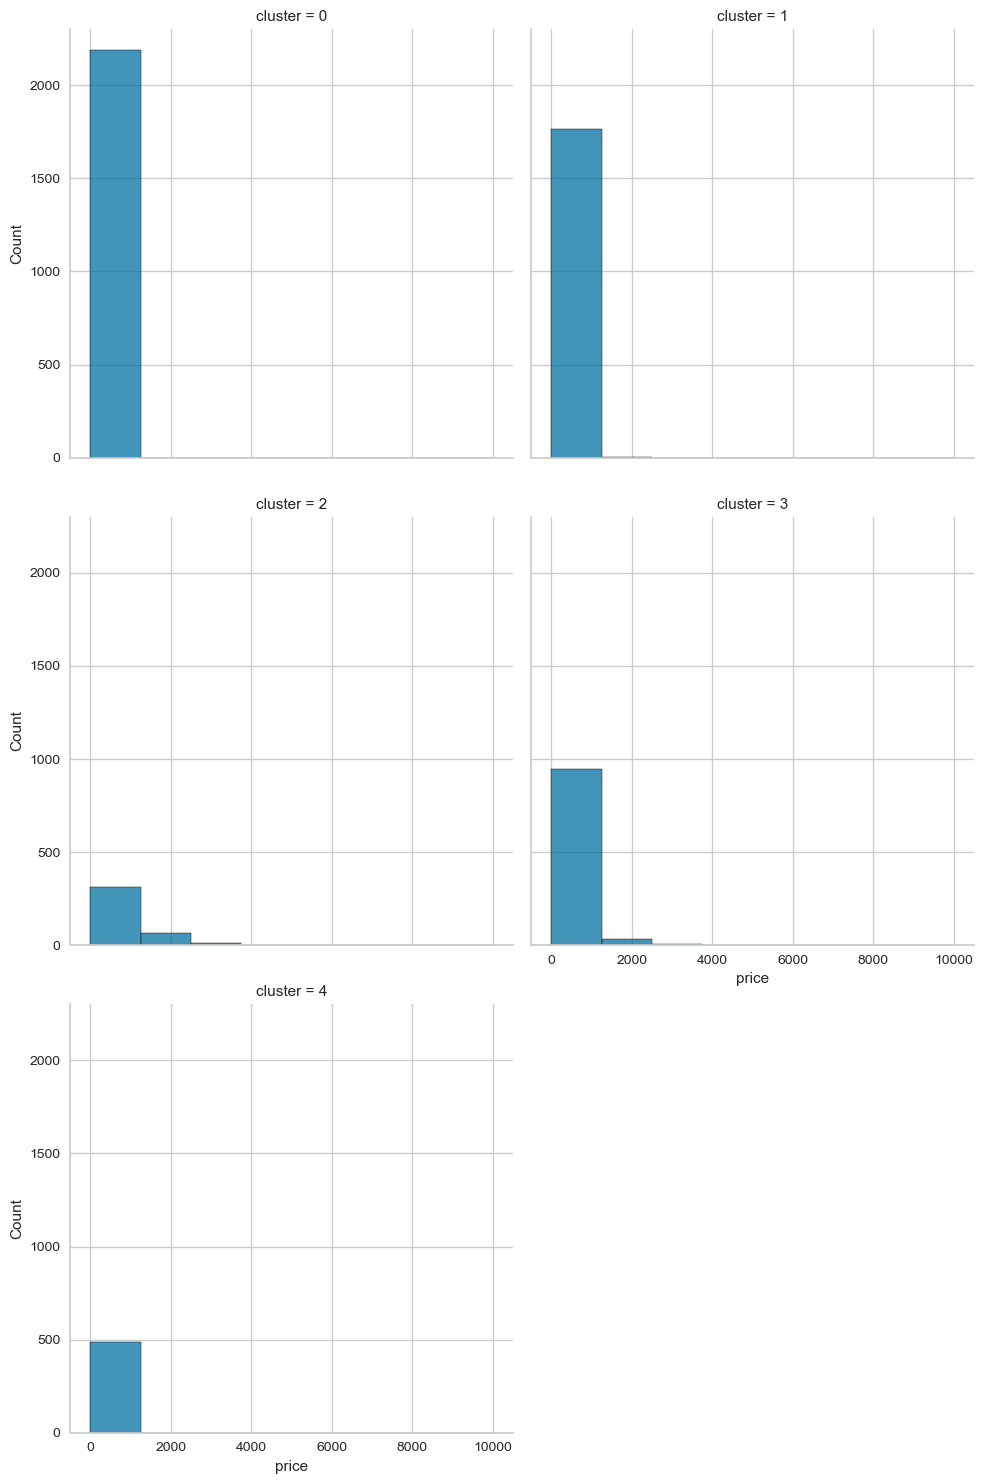

In [27]:
plt.figure(figsize=(8,4))
print("Price")
sns.displot(data=ATX_lisitng_dat_num, x="price", bins=8, col='cluster', col_wrap=2, common_bins=True)
plt.show()